In [115]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

from tunnel_book.preprocessing import load_image, downscale, depth_map, normalize_image
from tunnel_book.RAG import RAG

from skimage import color
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import slic
import networkx as nx

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# from skimage import segmentation, graph, color
# from tunnel_book.segmentation import get_msk_gen
# from tunnel_book.viz import show_anns, show_all_segmts_ind, save_layers
# from tunnel_book.cut import assign2layers_kmeans
# from tunnel_book.process_seg_img import obtain_all_objects, check_overlapping

In [197]:
img_name = "train"
ext = ".jpg"

img = load_image("dataset/" + img_name + ext)

depth = depth_map(img)
img = downscale(img, *depth.shape)

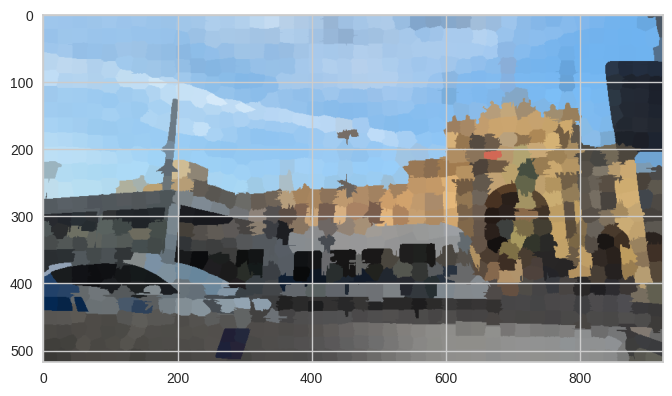

In [198]:
depth = normalize_image(depth_map(img)) * 100
img = downscale(img, *depth.shape)
cie_img = color.rgb2lab(img)

# for some reason slic works best with rgb pixel values (probably using wrong dist metric in cie?)
rgb_slic = slic(img, n_segments=1000, start_label=1, slic_zero=True)
plt.imshow(color.label2rgb(rgb_slic, img, kind='avg', bg_label=0))

In [199]:
# plt.figure(figsize=(22,12))
# 
# plt.subplot(121)
# plt.title('Input Image')
# plt.imshow(img)
# 
# plt.subplot(122)
# plt.title('Predicted Depth')
# plt.imshow(depth)
# 
# plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

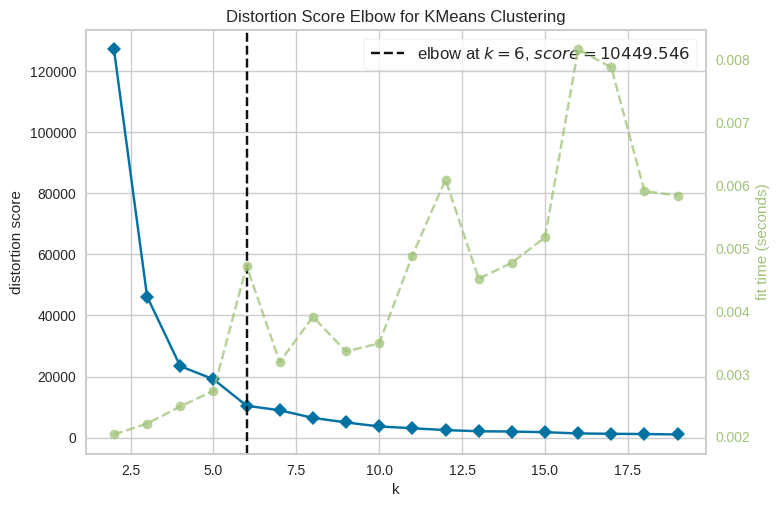

Optimal number of clusters: 6


In [200]:
depth_features = np.array([[np.mean(depth[m == rgb_slic])] for m in np.unique(rgb_slic)])

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20), metric='distortion', timings=True)
visualizer.fit(depth_features)
visualizer.show()

# when the k value here is high the result is probably be bad
optimalK = visualizer.elbow_value_
print(f"Optimal number of clusters: {optimalK}")

In [201]:
rag = RAG(img, depth, rgb_slic)

In [202]:
g = rag.graph.copy()
regions = rag.edge_nodes.copy()

while g.number_of_nodes() > optimalK:
    cheapest_edge_val = np.inf
    cheapest_edge = [0, 0]

    for n1 in regions:
        for n2 in nx.all_neighbors(g, n1):
            dst = 15 * (g.nodes[n1]['mean depth'] - g.nodes[n2]['mean depth']) ** 2 + (
                        g.nodes[n1]['pixel count'] + g.nodes[n2]['pixel count']) + g[n1][n2]['weight']
            if dst < cheapest_edge_val:
                cheapest_edge_val = dst
                cheapest_edge = [n1, n2]

    n1 = cheapest_edge[0]
    n2 = cheapest_edge[1]
    g.remove_edge(n1, n2)
    if n2 in regions:
        regions.remove(n2)

    g.nodes[n1]['mask'] = np.logical_or(g.nodes[n1]['mask'], g.nodes[n2]['mask'])
    g.nodes[n1]['pixel count'] += g.nodes[n2]['pixel count']
    g.nodes[n1]['total color'] = np.append(g.nodes[n1]['total color'], g.nodes[n2]['total color'], axis=0)
    g.nodes[n1]['total depth'] = np.append(g.nodes[n1]['total depth'], g.nodes[n2]['total depth'], axis=0)
    g.nodes[n1]['mean color'] = np.sum(g.nodes[n1]['total color'] / g.nodes[n1]['pixel count'], axis=0)
    g.nodes[n1]['mean depth'] = np.sum(g.nodes[n1]['total depth'] / g.nodes[n1]['pixel count'], axis=0)

    n1_con = []
    for c in nx.all_neighbors(g, n1):
        n1_con.append(c)
    for c in n1_con:
        g.remove_edge(n1, c)

    n2_con = []
    for c in nx.all_neighbors(g, n2):
        n2_con.append(c)
    for c in n2_con:
        g.remove_edge(n2, c)

    for n in np.unique(n1_con + n2_con):
        g.add_edge(n1, n)
        g[n1][n]['weight'] = (
            color.deltaE_cie76(g.nodes[n1]['mean color'], g.nodes[n]['mean color'])
            # abs(g.nodes[x]['mean depth'] - g.nodes[y]['mean depth'])
        )

    g.remove_node(n2)

RAG with 6 nodes and 8 edges
[1, 12, 23, 32, 586, 835]


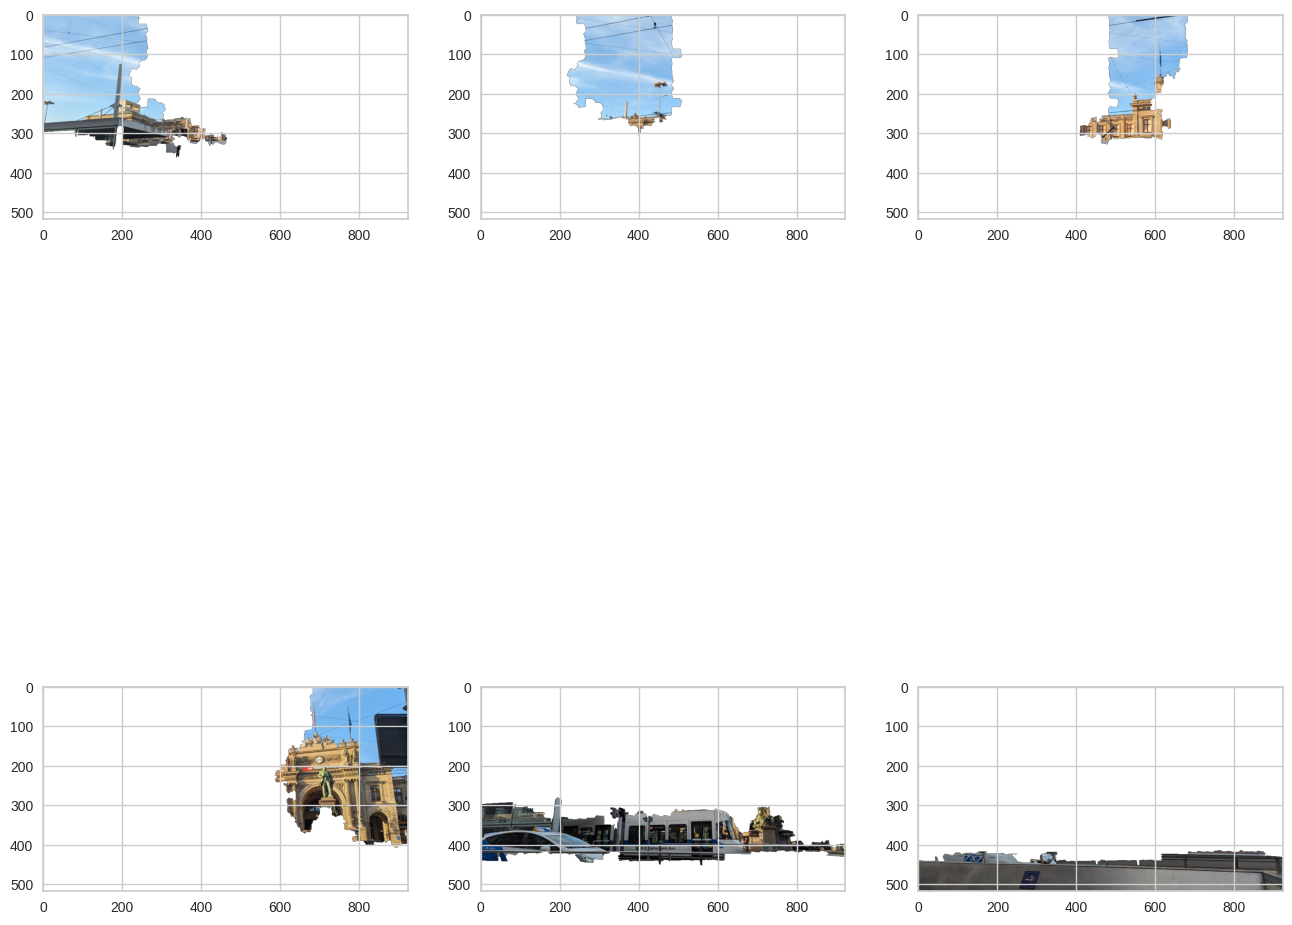

In [203]:
n, m = np.shape(depth)

print(g)
print(regions)
# print(img.dtype)
# print(np.min(img * 255), np.max(img * 255))

masks = []
images = []

plt.figure(figsize=(16, 16))

for i, reg in enumerate(regions):
    plt.subplot(231 + i)
    
    mask = g.nodes[reg]['mask']
    mask = binary_fill_holes(mask)
    masks.append(mask)

    # image with alpha channel
    image = np.zeros((n, m, 4), dtype=np.uint8)
    image[mask, 0:3] = img[mask] * 255.0
    image[mask, 3] = 255
    images.append(image)
    
    plt.imshow(image)

In [204]:
output_dir = "output2/"
output_dir = os.path.join(output_dir, img_name + '/')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

    cv2.imwrite(output_dir + img_name + '.png',
                cv2.cvtColor(np.array(img * 255.0, dtype=np.uint8), cv2.COLOR_RGB2BGR))
    
    for i, mask in enumerate(masks):
        np.save(output_dir + 'mask_' + str(i+1) + '.npy', mask)

    for i, image in enumerate(images):
        cv2.imwrite(output_dir + 'transparent_' + str(i+1) + '.png', cv2.cvtColor(image, cv2.COLOR_RGBA2BGRA))
        
    for i, image in enumerate(images):
        cv2.imwrite(output_dir + 'layer_' + str(i+1) + '.png', cv2.cvtColor(image, cv2.COLOR_RGBA2BGR))

# Testing

In [124]:
# object_masks = obtain_all_objects(get_msk_gen(), img)
# check_overlapping(object_masks)

In [125]:
# show_all_segmts_ind(object_masks, img)

In [126]:
# layers_idx, layers = assign2layers_kmeans(object_masks, depth, 3)
# save_layers(img, object_masks, layers_idx, ['/tmp/layer1.png','/tmp/layer2.png','/tmp/layer3.png'])

In [127]:
# n, m = np.shape(depth)
# segment_ids = np.unique(rgb_slic)
# 
# masks = np.array([(rgb_slic == i) for i in segment_ids])
# d_avgs = np.zeros((n, m), dtype='float')
# for mk in masks:
#     d_avgs[mk] = np.mean(depth[mk])
# 
# plt.imshow(d_avgs)

In [128]:
# # while this works I need to change the implementation a little bit to get edges and to change the loss function used
# 
# g = graph.rag_mean_color(img, rgb_slic)
# 
# # g = graph.rag_mean_color(depth, rgb_slic, mode='similarity')
# # g = graph.rag_mean_color(depth, rgb_slic)
# lc = graph.show_rag(rgb_slic, g, img)
# plt.colorbar(lc)

In [129]:
# n, m = np.shape(depth)
# 
# boundary_slic = np.zeros((n + 10, m + 10), dtype='int64')
# boundary_slic[5:-5,5:-5] = rgb_slic
# 
# boundary_depth = np.zeros((n + 10, m + 10))
# boundary_depth[5:-5,5:-5] = depth
# 
# boundary_cie_img = np.zeros((n + 10, m + 10, 3))
# boundary_cie_img[5:-5,5:-5,:] = cie_img
# 
# boundary_img = np.zeros((n + 10, m + 10, 3))
# boundary_img[5:-5,5:-5,:] = img
# 
# plt.imshow(boundary_slic)
# plt.colorbar()

In [130]:
## from tunnel_book.RAG import RAG
## 
## rag = RAG(img, depth, rgb_slic)

In [131]:
# sigma_c = 256
# sigma_d = 100
# 
# g = graph.RAG(boundary_slic, connectivity=2)
# 
# for n in g:
#     g.nodes[n].update(
#         {
#             'labels': [n],
#             'mask': None,
#             'pixel count': 0,
#             'total color': [],
#             'total depth': [],
#         }
#     )
# 
# for index in np.ndindex(boundary_slic.shape):
#     current = boundary_slic[index]
#     g.nodes[current]['pixel count'] += 1
#     g.nodes[current]['total color'].append(boundary_cie_img[index])
#     g.nodes[current]['total depth'].append(boundary_depth[index])
# 
# for n in g:
#     g.nodes[n]['mask'] = rgb_slic == n
#     g.nodes[n]['total color'] = np.array(g.nodes[n]['total color'], dtype='float64')
#     g.nodes[n]['total depth'] = np.array(g.nodes[n]['total depth'], dtype='float64')
#     g.nodes[n]['mean color'] = np.sum(g.nodes[n]['total color'] / g.nodes[n]['pixel count'], axis=0)
#     g.nodes[n]['mean depth'] = np.sum(g.nodes[n]['total depth'] / g.nodes[n]['pixel count'], axis=0)
# 
# for x, y, edge in g.edges(data=True):
#     # some kind of loss function with the distance, color difference, and segment anything result
#     edge['weight'] = (
#         color.deltaE_cie76(g.nodes[x]['mean color'], g.nodes[y]['mean color']) ** 2
#         # abs(g.nodes[x]['mean depth'] - g.nodes[y]['mean depth'])
#     )
#     # we will consider weight when we are actually collecting the superpixels into regions
#         # math.e ** (-(diff**2) / sigma)
#         # np.exp(-np.sum((g.nodes[x]['mean color'] - g.nodes[y]['mean color']) ** 2) / (2 * (sigma_c ** 2)))  # increase weight for color similarity
#         # *
#         # np.exp(-np.sum((g.nodes[x]['mean depth'] - g.nodes[y]['mean depth']) ** 2) / (2 * (sigma_d ** 2)))  # increase weight for depth similarity

    
# lc = graph.show_rag(boundary_slic, g, boundary_img)
## lc = graph.show_rag(rag.boundary_labels, rag.boundary_graph, rag.boundary_img)
## plt.colorbar(lc)

In [132]:
# regions = []
# for node in nx.all_neighbors(g, 0):
#     regions.append(node)
#     
# for n in regions:
#     g.remove_edge(n, 0)
# 
# g.remove_node(0)
# 
# lc = graph.show_rag(rgb_slic, g, img)
# lc = graph.show_rag(rgb_slic, g, img)

## plt.figure(figsize=(30, 20))
## lc = graph.show_rag(rag.labels, rag.graph, rag.img)
## plt.colorbar(lc)

In [133]:
# # maybe write a method for this block

# g = rag.graph.copy()
# regions = rag.edge_nodes.copy()
# 
# while g.number_of_nodes() > 3:
#     cheapest_edge_val = np.inf
#     cheapest_edge = [0, 0]
# 
#     for n1 in regions:
#         for n2 in nx.all_neighbors(g, n1):
#             dst = 15 * (g.nodes[n1]['mean depth'] - g.nodes[n2]['mean depth']) ** 2 + (g.nodes[n1]['pixel count'] + g.nodes[n2]['pixel count']) + g[n1][n2]['weight'] 
#             if dst < cheapest_edge_val:
#                 cheapest_edge_val = dst
#                 cheapest_edge = [n1, n2]
# 
#     n1 = cheapest_edge[0]
#     n2 = cheapest_edge[1]
#     g.remove_edge(n1, n2)
#     if n2 in regions:
#         regions.remove(n2)
# 
#     g.nodes[n1]['mask'] = np.logical_or(g.nodes[n1]['mask'], g.nodes[n2]['mask'])
#     g.nodes[n1]['pixel count'] += g.nodes[n2]['pixel count']
#     g.nodes[n1]['total color'] = np.append(g.nodes[n1]['total color'], g.nodes[n2]['total color'], axis=0)
#     g.nodes[n1]['total depth'] = np.append(g.nodes[n1]['total depth'], g.nodes[n2]['total depth'], axis=0)
#     g.nodes[n1]['mean color'] = np.sum(g.nodes[n1]['total color'] / g.nodes[n1]['pixel count'], axis=0)
#     g.nodes[n1]['mean depth'] = np.sum(g.nodes[n1]['total depth'] / g.nodes[n1]['pixel count'], axis=0)
#     
#     n1_con = []
#     for c in nx.all_neighbors(g, n1):
#         n1_con.append(c)
#     for c in n1_con:
#         g.remove_edge(n1, c)
# 
#     n2_con = []
#     for c in nx.all_neighbors(g, n2):
#         n2_con.append(c)
#     for c in n2_con:
#         g.remove_edge(n2, c)
# 
#     for n in np.unique(n1_con + n2_con):
#         g.add_edge(n1, n)
#         g[n1][n]['weight'] = (
#             color.deltaE_cie76(g.nodes[n1]['mean color'], g.nodes[n]['mean color'])
#             # abs(g.nodes[x]['mean depth'] - g.nodes[y]['mean depth'])
#         )
# 
#     g.remove_node(n2)

In [134]:
# n, m = np.shape(depth)
# 
# print(g)
# print(regions)
# 
# masks = []
# 
# plt.figure(figsize=(16,10))
# for i, reg in enumerate(regions):
#     plt.subplot(221 + i)
#     res = np.zeros((n, m, 3))
#     res[g.nodes[reg]['mask']] = img[g.nodes[reg]['mask']]
#     masks.append(g.nodes[reg]['mask'])
#     plt.imshow(res)
#     
# # print(g.nodes[1]['mask'].shape)
# # print(res.shape)

# TODO: keep the most salient objects together
# TODO: should attempt to push the depth amount to ensure that the different layers have significant enough difference in depth
# TODO: create a conda or pip env
# TODO: difference in superpixels should be more than just difference in average color and depth (could also consider difference in texture, saliency, and objects)

what does the edge weight mean?
- at the moment the edge weight is based on the difference in color and depth between superpixels
- this doesn't really make sense because a single object could be made from many colors
    - what if we used the information from the segment anything to get the objects then use superpixels to get a better outline
    - perform segment anything then find all the superpixels that fit inside the segments
    - then for superpixels within a segment make the weights large (and use medium weights for when the color changes but still within same segment)

large weights for parts to slice or small weights for parts to slice
- small weights for the parts to slice
- large weights for parts to keep together
    - or small weights for parts to keep together
    - small difference in depth to keep together
- small dist for depth and color to keep together (choose the smallest disparity value to add)

how do we also consider the depth of the object?
- consider 4 (or as many layers as we want) clouds that are initialized to the kmeans averages for depths over the entire image
- begin by taking the 4 points next to the edge with the nearest depth values
- then we continusouly merge adjacent superpixels based on edge weight (the difference in color and segment anything result) and the difference in average depth for that superpixel
- each time we can update the average depth for our cloud as use that updated depth when looking for the next superpixel

instead of initalizing only 4 clouds we can allow all the edge nodes to be clouds and iterate until there are only 4 left

In [135]:
# from tunnel_book.saliency_map import FasaSaliencyMapping
# import cv2

In [136]:
# my_map = FasaSaliencyMapping(img.shape[0], img.shape[1])  # init the saliency object
# image_salient_1 = my_map.returnMask(color.rgb2lab(img), tot_bins=8, format='LAB')  # get the mask from the original image
# image_salient_1 = cv2.GaussianBlur(image_salient_1, (3,3), 1)  # applying gaussin blur to make it pretty
# 
# print(image_salient_1.shape)
# plt.figure(figsize=(16,10))
# # plt.imshow(image_salient_1 > 128)
# plt.imshow(normalize_image(image_salient_1))
# # plt.imshow(np.exp(-image_salient_1/256))
# plt.colorbar()

In [137]:
# plt.figure(figsize=(16,10))
# plt.imshow(color.label2rgb(rgb_slic, image_salient_1, kind='avg', bg_label=0))
# plt.colorbar()